# Chapter 5: Word Embeddings

## Using pre-trained embeddings

In general, you will train your own word2vec or GloVe model from scratch only if you have a very large amount of very specialized text. By far the most common use case for Embeddings is to use pre-trained embeddings in some way in your network. The three main ways in which you would use embeddings in your network are as follows:
- Learn embeddings from scratch 
- Fine-tune learned embeddings from pre-trained GloVe/word2vec models 
- Look up embeddings from pre-trained GloVe/word2vec models 

In the first option, the embedding weights are initialized to small random values and trained using backpropagation. You saw this in the examples for skip-gram and CBOW models in Keras. This is the default mode when you use a Keras Embedding layer in your network.

In the second option, you build a weight matrix from a pre-trained model and initialize the weights of your embedding layer with this weight matrix. The network will update these weights using backpropagation, but the model will converge faster because of good starting weights.

The third option is to look up word embeddings from a pre-trained model, and transform your input to embedded vectors. You can then train any machine learning model (that is, not necessarily even a deep learning network) on the transformed data. If the pre-trained model is trained on a similar domain as the target domain, this usually works very well and is the least expensive option.

For general use with English language text, you can use Google's word2vec model trained over 10 billion words from the Google news dataset. The vocabulary size is about 3 million words and the dimensionality of the embedding is 300. The Google news model (about 1.5 GB) can be downloaded from here: https://drive.google.com/file/d/0B7XkCwpI5KDYNl NUTTlSS21pQmM/edit?usp=sharing.

Similarly, a pre-trained model trained on 6 billion tokens from English Wikipedia and the gigaword corpus can be downloaded from the GloVe site. The vocabulary size is about 400,000 words and the download provides vectors with dimensions 50, 100, 200, and 300. The model size is about 822 MB. Here is the direct download URL (http://nlp.stanford. edu/data/glove.6B.zip) for this model. Larger models based on the Common Crawl and Twitter are also available from the same location.

In the following sections, we will look at how to use these pre-trained models in the three ways listed.

### Learn embeddings from scratch

In this example, we will train a one-dimensional **convolutional neural network (CNN)** to classify sentences as either positive or negative. You have already seen how to classify images using two-dimensional CNNs in `*Chapter 3, Deep Learning with ConvNets*`. Recall that CNNs exploit spatial structure in images by enforcing local connectivity between neurons of adjacent layers.

Words in sentences exhibit linear structure in the same way as images exhibit spatial structure. Traditional (non-deep learning) NLP approaches to language modeling involve creating word *n*-grams (https://en.wikipedia.org/wiki/N-gram) to exploit this linear structure inherent among words. One-dimensional CNNs do something similar, learning convolution filters that operate on sentences a few words at a time, and max pooling the results to create a vector that represents the most important ideas in the sentence.

There is another class of neural network, called **recurrent neural network (RNN)**, which is specially designed to handle sequence data, including text, which is a sequence of words. The processing in RNNs is different from that in a CNN. We will learn about RNNs in a future chapter.

In our example network, the input text is converted to a sequence of word indices. Note that we have used the natural language toolkit (NLTK) to parse the text into sentences and words. We could also have used regular expressions to do this, but the statistical models supplied by NLTK are more powerful at parsing than regular expressions. If you are working with word embeddings, it is very likely that you are also working with NLP, in which case you would have NLTK installed already.

This link (http://www.nltk.org/install.html) has information to help you install NLTK on your machine. You will also need to install NLTK data, which is some trained corpora that comes standard with NLTK. Installation instructions for NLTK data are available here: http://www.nl tk.org/data.html.

The sequence of word indices is fed into an array of embedding layers of a set size (in our case, the number of words in the longest sentence). The embedding layer is initialized by default to random values. The output of the embedding layer is connected to a 1D convolutional layer that convolves (in our example) word trigrams in 256 different ways (essentially, it applies different learned linear combinations of weights on the word embeddings). These features are then pooled into a single pooled word by a global max pooling layer. This vector (256) is then input to a dense layer, which outputs a vector (2). A softmax activation will return a pair of probabilities, one corresponding to positive sentiment and another corresponding to negative sentiment. The network is shown in the following figure:

<img src="./images/learn_embeddings_from_scratch.png" alt="Drawing" style="width: 400px;"/>

Let us look at how to code this up using Keras. First we declare our imports. Right after the constants, you will notice that I set the `random.seed` value to `42`. This is because we want consistent results between runs. Since the initializations of the weight matrices are random, differences in initialization can lead to differences in output, so this is a way to control that:

In [1]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
pd.set_option("display.max_colwidth", 500)

In [5]:
np.random.seed(42)
random_state = 42

In [6]:
train_df  = pd.read_table('data/UMICH_SI650_train_data.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_df  = pd.read_table('data/UMICH_SI650_test_data.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [7]:
train_df.head(5)

,sentiment,comment
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


In [8]:
test_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillary Clinton."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awesome: P Remind me to post the million and one pictures that I took when I get back to Markham!..."
3,"Have to say, I hate Paris Hilton's behavior but I do think she's kinda cute.."
4,i will love the lakers.


In [9]:
# Inspect how many are positive and negative sentiments
train_df.sentiment.value_counts()

1    3995
0    3091
Name: sentiment, dtype: int64

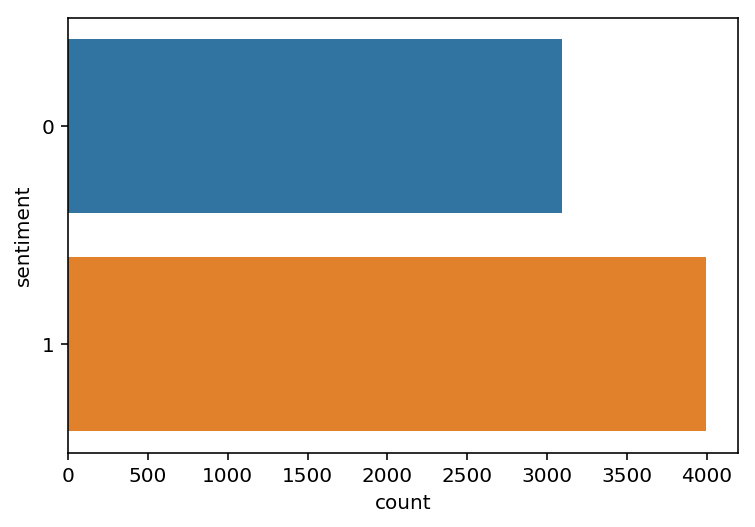

In [10]:
sns.countplot(y='sentiment', data=train_df);

In [11]:
# How many records in all in the training set
len(train_df)

7086

We declare our constants. For all subsequent examples in this chapter, we will classify sentences from the UMICH SI650 sentiment classification competition on Kaggle. The dataset has around 7,000 sentences, and is labeled `1` for positive and `0` for negative. The `INPUT_FILE` defines the path to this file of sentences and labels. The format of the file is a sentiment label (0 or 1) followed by a tab, followed by a sentence.

The `VOCAB_SIZE` setting indicates that we will consider only the top 5,000 tokens in the text. The `EMBED_SIZE` setting is the size of the embedding that will be generated by the embedding layer in the network. `NUM_FILTERS` is the number of convolution filters we will train for our convolution layer, and `NUM_WORDS` is the size of each filter, that is, how many words we will convolve at a time. The `BATCH_SIZE` and `NUM_EPOCHS` is the number of records to feed the network each time and how many times we will run through the entire dataset during training:

In [12]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"
VOCAB_SIZE  = 5000
EMBED_SIZE  = 100
NUM_FILTERS = 256
NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 20

In the next block, we first read our input sentences and construct our vocabulary out of the most frequent words in the corpus. We then use this vocabulary to convert our input sentences into a list of word indices:

In [13]:
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    maxlen = 0
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [14]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

We pad each of our sentences to predetermined length `maxlen` (in this case the number of words in the longest sentence in the training set). We also convert our labels to categorical format using a Keras utility function. The last two steps are a standard workflow for handling text input that we will see again and again:

In [15]:
xs, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [16]:
X = pad_sequences(xs, maxlen=maxlen)
y = np_utils.to_categorical(ys)

Finally, we split up our data into a 70/30 training and test set. The data is now in a form ready to be fed into the network:

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

We define the network that we described earlier in this section:

In [18]:
def create_model(initial_weights=None, trainable=True):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_sz, 
                    output_dim=EMBED_SIZE, 
                    input_length=maxlen, 
                    weights=initial_weights,
                    trainable=trainable))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(2, activation='softmax'))
    return model

In [19]:
model = create_model()

In [20]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 100)           199400    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 22, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           77056     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 276,970
Trainable params: 276,970
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# plot graph
import pydot_ng
from keras.utils import plot_model
plot_model(model, to_file='images/model_learn_embeddings_from_scratch.png', show_shapes=True, show_layer_names=True)

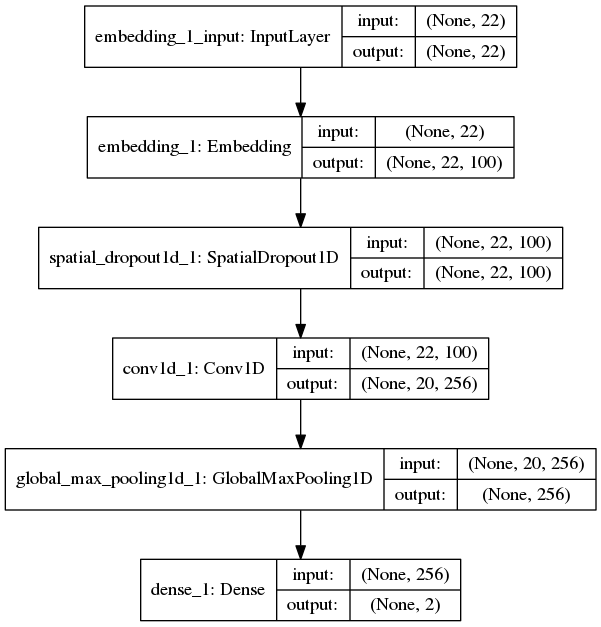

In [22]:
from IPython.display import Image
Image(filename='images/model_learn_embeddings_from_scratch.png')

We then compile the model. Since our target is binary (positive or negative) we choose `categorical_crossentropy` as our loss function. For the optimizer, we choose `adam`. We then train the model using our training set, using a batch size of 64 and training for 20 epochs:

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 2s 347us/step - loss: 0.2686 - acc: 0.9060 - val_loss: 0.0292 - val_acc: 0.9901
Epoch 2/20
4960/4960 [==============================] - 1s 104us/step - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0158 - val_acc: 0.9958
Epoch 3/20
4960/4960 [==============================] - 1s 104us/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0137 - val_acc: 0.9953
Epoch 4/20
4960/4960 [==============================] - 1s 102us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0137 - val_acc: 0.9958
Epoch 5/20
4960/4960 [==============================] - 1s 103us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0123 - val_acc: 0.9948
Epoch 6/20
4960/4960 [==============================] - 1s 103us/step - loss: 9.7091e-04 - acc: 0.9998 - val_loss: 0.0119 - val_acc: 0.9948
Epoch 7/20
4960/4960 [==============================] - 1s 103us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0133 - val_acc: 0.9

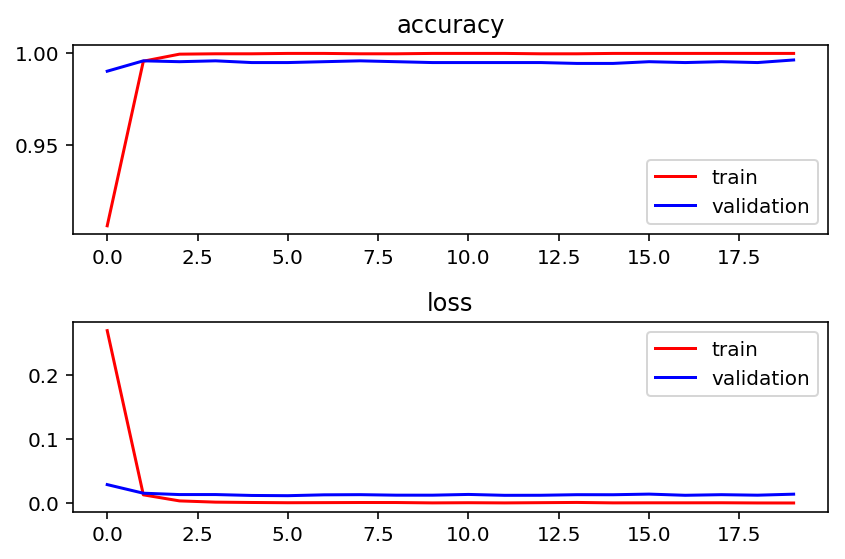

In [25]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [26]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.014, accuracy: 0.996


## Fine-tuning learned embeddings from word2vec

In this example, we will use the same network as the one we used to learn our embeddings from scratch. In terms of code, the only major difference is an extra block of code to load the word2vec model and build up the weight matrix for the embedding layer.

As always, we start with the imports and set up a random seed for repeatability. In addition to the imports we have seen previously, there is an additional one to import the word2vec model from gensim:

In [27]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [29]:
pd.set_option("display.max_colwidth", 500)

In [30]:
np.random.seed(42)
random_state = 42

Next up is setting up the constants. The only difference here is that we reduced the `NUM_EPOCHS` setting from `20` to `10`. Recall that initializing the matrix with values from a pre-trained model tends to set them to good values that converge faster:

In [31]:
INPUT_FILE     = "data/UMICH_SI650_train_data.txt"
WORD2VEC_MODEL = "data/GoogleNews-vectors-negative300.bin.gz"
VOCAB_SIZE     = 5000
EMBED_SIZE     = 300
NUM_FILTERS    = 256
NUM_WORDS      = 3
BATCH_SIZE     = 64
NUM_EPOCHS     = 10

The next block extracts the words from the dataset and creates a vocabulary of the most frequent terms, then parses the dataset again to create a list of padded word lists. It also converts the labels to categorical format. Finally, it splits the data into a training and a test set. This block is identical to the previous example and has been explained in depth there:

In [32]:
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    maxlen = 0
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [33]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [34]:
xs, ys = [], []
with open(file='data/UMICH_SI650_train_data.txt', mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [35]:
X = pad_sequences(xs, maxlen=maxlen)
y = np_utils.to_categorical(ys)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [37]:
TEST_FILE  = "data/UMICH_SI650_test_data.txt"

In [38]:
xs
with open(file=TEST_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    wids = []
    for sentence in fin:
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if word in word2index:
            wids.append(word2index[word])
        xs.append(np.array(wids))

In [39]:
X_test = pad_sequences(xs, maxlen=maxlen)

The next block loads up the word2vec model from a pre-trained model. This model is trained with about 10 billion words of Google News articles and has a vocabulary size of 3 million. We load it and look up embedding vectors from it for words in our vocabulary, and write out the embedding vector into our weight matrix `word2vec_embedding_weights`. Rows of this weight matrix correspond to words in the vocabulary, and columns of each row constitute the embedding vector for the word.

The dimensions of the `word2vec_embedding_weights` matrix is `vocab_sz` and `EMBED_SIZE`. The `vocab_sz` is one more than the maximum number of unique terms in the vocabulary, the additional pseudo-token `_UNK_` representing words that are not seen in the vocabulary.

Note that it is possible that some words in our vocabulary may not be there in the Google News word2vec model, so when we encounter such words, the embedding vectors for them remain at the default value of all zeros:

In [40]:
# load word2vec model
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)
word2vec_embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
for word, index in word2index.items():
    try:
        word2vec_embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

We define our network. The difference in this block from our previous example is that we initialize the weights of the embedding layer with the `word2vec_embedding_weights` matrix we built in the previous block:

In [41]:
model = create_model(initial_weights=[word2vec_embedding_weights], trainable=True)

We then compile our model with the categorical cross-entropy loss function and the Adam optimizer, and train the network with batch size 64 and for 10 epochs, then evaluate the trained model:

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s 224us/step - loss: 0.1108 - acc: 0.9593 - val_loss: 0.0158 - val_acc: 0.9944
Epoch 2/10
4960/4960 [==============================] - 1s 115us/step - loss: 0.0058 - acc: 0.9986 - val_loss: 0.0120 - val_acc: 0.9962
Epoch 3/10
4960/4960 [==============================] - 1s 115us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0113 - val_acc: 0.9967
Epoch 4/10
4960/4960 [==============================] - 1s 115us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0139 - val_acc: 0.9967
Epoch 5/10
4960/4960 [==============================] - 1s 115us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0116 - val_acc: 0.9958
Epoch 6/10
4960/4960 [==============================] - 1s 116us/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0113 - val_acc: 0.9962
Epoch 7/10
4960/4960 [==============================] - 1s 114us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0130 - val_acc: 0.9972


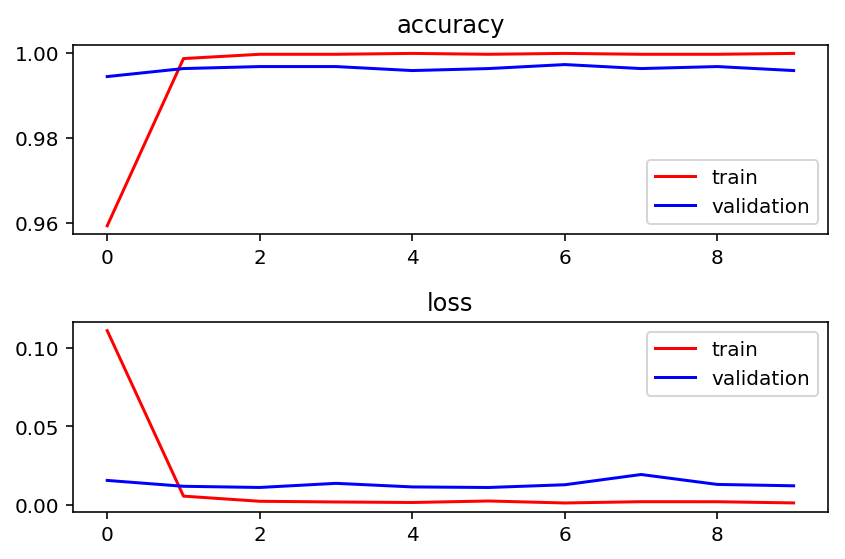

In [44]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [45]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.012, accuracy: 0.996


The model gives us an accuracy of 99.4% on the test set after 10 epochs of training. In the previous example, we got an accuracy of 99.6% accuracy after 20 epochs.

In [46]:
# make predictions
y_pred = model.predict_classes(X_test)

In [47]:
# How many negative and positive classes
pd.Series(y_pred).value_counts()

1    37045
0     3093
dtype: int64

In [48]:
# Let's sample some of the predictions
import random
sample = random.sample(range(len(test_df)), 15)

for sentiment, comment in zip(y_pred[sample], test_df.loc[sample].comment):
    print(sentiment, comment)

1 personally, i still love my 1999 toyota camry, 4 cylinder, 35mpg, gray, comfy, smooth, dependable....
1 i love my honda...
1 Then we had stupid trivia about San Francisco and sci fi tv so we left...
1 I want a new MacBook....
1 I think Angelina Jolie is so much more beautiful than Jennifer Anniston, who, by the way, is majorly OVERRATED.
1 i hate 3 paris hilton, halary duff, lindsay lohan.
1 It was really ironic that he spent the first part of class talking about his own professor at Harvard who was a pompous arrogant ass.
1 After John changed the tire and we swapped Why AAA Sucks stories, we walked back to Barnes and Noble so I could get my graphic novel and John could wash his hands.
1 Momentarily ignoring the bias of recently moving here, it does seems Seattle is in a good position to ask questions about space distribution ( real estate ) and disruptive tools ( technology )..
1 I hate Seattle..
1 The Honda is awesome.
1 well, i had a piece of crap toyota celica but it died in port

## Fine-tuning learned embeddings from GloVe

Fine tuning using pre-trained GloVe embeddings is very similar to fine tuning using pre- trained word2vec embeddings. In fact, all of the code, except for the block that builds the weight matrix for the embedding layer, is identical. Since we have already seen this code twice, I will just focus on the block of code that builds the weight matrix from the GloVe embeddings.

GloVe embeddings come in various flavors. We use the model pre-trained on 6 billion tokens from the English Wikipedia and the gigaword corpus. The vocabulary size for the model is about 400,000, and the download provides vectors of dimensions 50, 100, 200, and 300. We will use embeddings from the 300 dimensional model.

In [49]:
import numpy as np
import pandas as pd

import collections

import re, nltk

import keras
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [50]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"
GLOVE_MODEL = "data/glove.6B.300d.txt"
VOCAB_SIZE  = 5000
EMBED_SIZE  = 300
NUM_FILTERS = 256
NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 10

In [51]:
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    maxlen = 0
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [52]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [53]:
xs, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [54]:
X = keras.preprocessing.sequence.pad_sequences(xs, maxlen=maxlen)
y = keras.utils.np_utils.to_categorical(ys)

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

The only thing we need to change in the code for the previous example is to replace the block that instantiated a word2vec model and loaded the embedding matrix using the following block of code. If we use a model with vector size other than 300, then we also need to update `EMBED_SIZE`.

The vectors are provided in space-delimited text format, so the first step is to read the code into a dictionary, `word2emb`. This is analogous to the line instantiating the Word2Vec model in our previous example:

In [56]:
# load GloVe vectors
word2emb = {}
with open(GLOVE_MODEL, "rb") as fglove:
    for line in fglove:
        cols = line.strip().split()
        word = cols[0]
        embedding = np.array(cols[1:], dtype="float32")
        word2emb[word] = embedding

We then instantiate an embedding weight matrix of size (`vocab_sz` and `EMBED_SIZE`) and populate the vectors from the `word2emb` dictionary. Vectors for words that are found in the vocabulary but not in the GloVe model remain set to all zeros:

In [57]:
glove_embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
for word, index in word2index.items():
    try:
        glove_embedding_weights[index, :] = word2emb[word]
    except KeyError:
        pass

In [58]:
model = create_model(initial_weights=[glove_embedding_weights], trainable=True)

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s 238us/step - loss: 0.6906 - acc: 0.5599 - val_loss: 0.6881 - val_acc: 0.5701
Epoch 2/10
4960/4960 [==============================] - 1s 136us/step - loss: 0.6874 - acc: 0.5611 - val_loss: 0.6852 - val_acc: 0.5701
Epoch 3/10
4960/4960 [==============================] - 1s 123us/step - loss: 0.6862 - acc: 0.5611 - val_loss: 0.6842 - val_acc: 0.5701
Epoch 4/10
4960/4960 [==============================] - 1s 116us/step - loss: 0.6859 - acc: 0.5611 - val_loss: 0.6838 - val_acc: 0.5701
Epoch 5/10
4960/4960 [==============================] - 1s 116us/step - loss: 0.6858 - acc: 0.5611 - val_loss: 0.6836 - val_acc: 0.5701
Epoch 6/10
4960/4960 [==============================] - 1s 116us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6835 - val_acc: 0.5701
Epoch 7/10
4960/4960 [==============================] - 1s 114us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6835 - val_acc: 0.5701


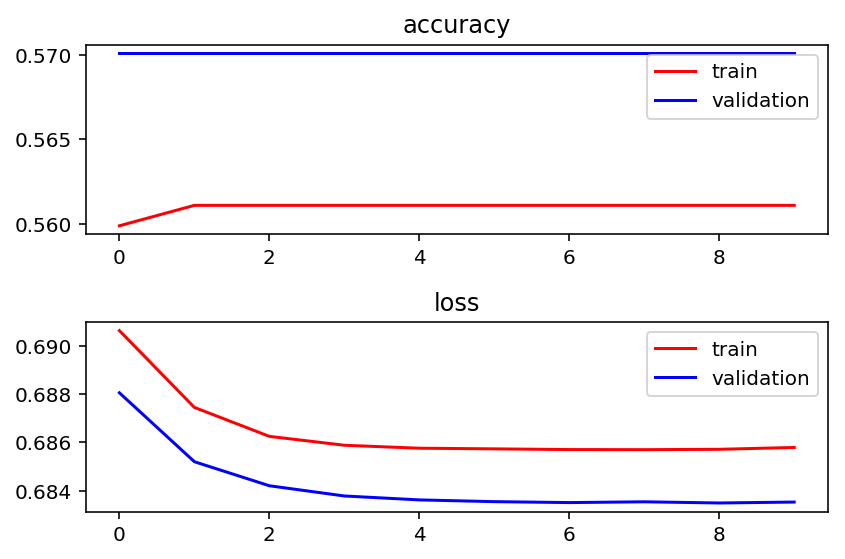

In [61]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [62]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.684, accuracy: 0.570


This gives us 57.0% accuracy in 10 epochs, which is not at all as good as the results we got from fine-tuning the network using word2vec embedding_weights.

## Transfer Learning: Look up embeddings

Our final strategy is to look up embeddings from pre-trained networks. The simplest way to do this with the current examples is to just set the `trainable` parameter of the embedding layer to `False`. This ensures that backpropagation will not update the weights on the embedding layer:

In [63]:
VOCAB_SIZE  = 5000
EMBED_SIZE  = 300
NUM_FILTERS = 256
NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 10

In [64]:
model = create_model(initial_weights=[word2vec_embedding_weights], trainable=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, 
                epochs=NUM_EPOCHS, 
                validation_data=(X_valid, y_valid), 
                shuffle=True)
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s 161us/step - loss: 0.1172 - acc: 0.9637 - val_loss: 0.0235 - val_acc: 0.9920
Epoch 2/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.0126 - acc: 0.9968 - val_loss: 0.0170 - val_acc: 0.9934
Epoch 3/10
4960/4960 [==============================] - 0s 87us/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.0166 - val_acc: 0.9958
Epoch 4/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.0034 - acc: 0.9998 - val_loss: 0.0148 - val_acc: 0.9958
Epoch 5/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0142 - val_acc: 0.9953
Epoch 6/10
4960/4960 [==============================] - 0s 87us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0156 - val_acc: 0.9958
Epoch 7/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0158 - val_acc: 0.9958
Epoch 

In [65]:
model = create_model(initial_weights=[glove_embedding_weights], trainable=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, 
                epochs=NUM_EPOCHS, 
                validation_data=(X_valid, y_valid), 
                shuffle=True)
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s 165us/step - loss: 0.6904 - acc: 0.5567 - val_loss: 0.6872 - val_acc: 0.5701
Epoch 2/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.6872 - acc: 0.5611 - val_loss: 0.6849 - val_acc: 0.5701
Epoch 3/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.6862 - acc: 0.5611 - val_loss: 0.6841 - val_acc: 0.5701
Epoch 4/10
4960/4960 [==============================] - 0s 86us/step - loss: 0.6859 - acc: 0.5611 - val_loss: 0.6838 - val_acc: 0.5701
Epoch 5/10
4960/4960 [==============================] - 0s 87us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6836 - val_acc: 0.5701
Epoch 6/10
4960/4960 [==============================] - 0s 87us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6836 - val_acc: 0.5701
Epoch 7/10
4960/4960 [==============================] - 0s 85us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6835 - val_acc: 0.5701
Epoch 

Setting this value with the word2vec and GloVe examples gave us accuracies of 57.0% and 99.5% respectively after 10 epochs of training.

### Transfer Learning: Look up embeddings from Glove

However, in general, this is not how you would use pre-trained embeddings in your code. Typically, it involves preprocessing your dataset to create word vectors by looking up words in one of the pre-trained models, and then using this data to train some other model. The second model would not contain an Embedding layer, and may not even be a deep learning network.

The following example describes a dense network that takes as its input a vector of size 100, representing a sentence, and outputs a 1 or 0 for positive or negative sentiment. Our dataset is still the one from the UMICH S1650 sentiment classification competition with around 7,000 sentences.

As previously, large parts of the code are repeated, so we only explain the parts that are new or otherwise need explanation.

We begin with the imports, set the random seed for repeatability, and set some constant values. In order to create the 100-dimensional vectors for each sentence, we add up the GloVe 100-dimensional vectors for the words in the sentence, so we choose the glove.6B.100d.txt file:

In [66]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [67]:
np.random.seed(42)
random_state = 42

In [68]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"
GLOVE_MODEL = "data/glove.6B.100d.txt"
VOCAB_SIZE  = 5000
EMBED_SIZE  = 100
#NUM_FILTERS = 256
#NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 10

The next block reads the sentences and creates a word frequency table. From this, the most common 5,000 tokens are selected and lookup tables (from word to word index and back) are created. In addition, we create a pseudo-token `_UNK_` for tokens that do not exist in the vocabulary. Using these lookup tables, we convert each sentence to a sequence of word IDs, padding these sequences so that all sequences are of the same length (the maximum number of words in a sentence in the training set). We also convert the labels to categorical format:

In [69]:
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    maxlen = 0
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [70]:
# creating vocabulary
word2index = collections.defaultdict(int)
word2index["_UNK_"] = 0
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
index2word[0] = "_UNK_"

In [71]:
# creating word sequences
ws, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        ws.append(wids)

In [72]:
words = [index2word[wid] for wid in ws[0]]
words

['da', 'vinci', 'code', 'book', 'awesome']

In [73]:
W = keras.preprocessing.sequence.pad_sequences(ws, maxlen=maxlen)
y = keras.utils.np_utils.to_categorical(ys)

We load the GloVe vectors into a dictionary. If we wanted to use word2vec here, all we have to do is replace this block with a gensim `KeyedVectors.load_word2vec_format()` call and replace the following block to look up the word2vec model instead of the word2emb dictionary:

In [74]:
# load GloVe vectors
word2emb = {}
with open(GLOVE_MODEL, "rb") as fglove:
    for line in fglove:
        cols = line.strip().split()
        word = cols[0]
        embedding = np.array(cols[1:], dtype="float32")
        word2emb[word] = embedding

The next block looks up the words for each sentence from the word ID matrix W and populates a matrix E with the corresponding embedding vector. These embedding vectors are then added to create a sentence vector, which is written back into the X matrix. The output of this code block is the matrix `X` of size (`num_records` and `EMBED_SIZE`):

In [75]:
# transferring glove embeddings
X = np.zeros((W.shape[0], EMBED_SIZE))
for i in range(W.shape[0]):
    E = np.zeros((EMBED_SIZE, maxlen))
    words = [index2word[wid] for wid in W[i].tolist()]
    for j in range(maxlen):
        try:
            E[:, j] = word2emb[words[j]]
        except KeyError:
            pass
    X[i, :] = np.sum(E, axis=1)

We have now preprocessed our data using the pre-trained model and are ready to use it to train and evaluate our final model. Let us split the data into 70/30 training/test as usual:

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [77]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(4960, 100) (2126, 100) (4960, 2) (2126, 2)


The network we will train for doing the sentiment analysis task is a simple dense network. We compile it with a categorical cross-entropy loss function and the Adam optimizer, and train it with the sentence vectors that we built out of the pre-trained embeddings. Finally, we evaluate the model on the 30% test set:

In [78]:
model = Sequential()
model.add(Dense(32, input_dim=EMBED_SIZE, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

In [79]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s 181us/step - loss: 0.6904 - acc: 0.5575 - val_loss: 0.6875 - val_acc: 0.5701
Epoch 2/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.6873 - acc: 0.5611 - val_loss: 0.6851 - val_acc: 0.5701
Epoch 3/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.6862 - acc: 0.5611 - val_loss: 0.6841 - val_acc: 0.5701
Epoch 4/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.6859 - acc: 0.5611 - val_loss: 0.6837 - val_acc: 0.5701
Epoch 5/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.6858 - acc: 0.5611 - val_loss: 0.6836 - val_acc: 0.5701
Epoch 6/10
4960/4960 [==============================] - 0s 67us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6835 - val_acc: 0.5701
Epoch 7/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.6857 - acc: 0.5611 - val_loss: 0.6835 - val_acc: 0.5701
Epoch 

In [81]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.683, accuracy: 0.570


### Transfer Learning: Look up embeddings from word2vec

In [82]:
NPUT_FILE = "data/umich-sentiment-train.txt"
WORD2VEC_MODEL = "data/GoogleNews-vectors-negative300.bin.gz"
VOCAB_SIZE = 5000
EMBED_SIZE = 300
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [83]:
# load word2vec vectors
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)

In [84]:
# transferring word2vec embeddings
X = np.zeros((W.shape[0], EMBED_SIZE))
for i in range(W.shape[0]):
    E = np.zeros((EMBED_SIZE, maxlen))
    words = [index2word[wid] for wid in W[i].tolist()]
    for j in range(maxlen):
        try:
            E[:, j] = word2vec[words[j]]
        except KeyError:
            pass
    X[i, :] = np.sum(E, axis=1)

We have now preprocessed our data using the pre-trained model and are ready to use it to train and evaluate our final model. Let us split the data into 70/30 training/test as usual:

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [86]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(4960, 300) (2126, 300) (4960, 2) (2126, 2)


In [87]:
model = Sequential()
model.add(Dense(32, input_dim=EMBED_SIZE, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

In [88]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [89]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Train on 4960 samples, validate on 2126 samples
Epoch 1/10
4960/4960 [==============================] - 1s 191us/step - loss: 0.2996 - acc: 0.8907 - val_loss: 0.1059 - val_acc: 0.9774
Epoch 2/10
4960/4960 [==============================] - 0s 67us/step - loss: 0.0752 - acc: 0.9847 - val_loss: 0.0613 - val_acc: 0.9840
Epoch 3/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.0407 - acc: 0.9925 - val_loss: 0.0533 - val_acc: 0.9882
Epoch 4/10
4960/4960 [==============================] - 0s 65us/step - loss: 0.0321 - acc: 0.9917 - val_loss: 0.0492 - val_acc: 0.9864
Epoch 5/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.0230 - acc: 0.9933 - val_loss: 0.0459 - val_acc: 0.9873
Epoch 6/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.0173 - acc: 0.9950 - val_loss: 0.0443 - val_acc: 0.9887
Epoch 7/10
4960/4960 [==============================] - 0s 66us/step - loss: 0.0169 - acc: 0.9948 - val_loss: 0.0433 - val_acc: 0.9911
Epoch 

In [90]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.045, accuracy: 0.992


The dense network gives us 57.0% accuracy on the validation set after 10 epochs of training when preprocessed with the 100-dimensional GloVe embeddings. When preprocessed with the word2vec embeddings (300-dimensional fixed) the network gives us 99.1% on the validation set.